## Machine Learning to Predict Booking Cancellation

#### Steps:
- Select some valuable and relevant features to our analysis by checking the correlation.
- Compare Label Encoder and Dummy Variables to get the best encoding method to our model.
- Feature Selection by SelectKBest.
- Split dataset to train data and test data.
- Predict the data by using LogisticRegression, KNNeighbors, and RandomForestClassifier.
- Compare models and select the best.
- Hyperparameter tuning the best default model.
- Compare the results.

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
bookings = pd.read_csv('data_cleaned.csv')

### Numerical Feature Selection

In [3]:
bookings.corr()['is_canceled'].abs().sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.298775
total_of_special_requests         0.231599
required_car_parking_spaces       0.190256
booking_changes                   0.138642
previous_cancellations            0.117344
agent                             0.110694
company                           0.092282
is_repeated_guest                 0.074339
days_in_waiting_list              0.059361
adults                            0.058783
previous_bookings_not_canceled    0.053890
price                             0.049536
adr                               0.049323
babies                            0.032177
stays_in_week_nights              0.025363
total_nights                      0.017566
adr_pp                            0.011659
arrival_month                     0.010551
arrival_date_week_number          0.007728
children                          0.006321
arrival_date_day_of_month         0.006242
arrival_date_year                 0.005808
stays_in_we

#### Drop some irrelevant features to our analysis

By looking at the correlation, we will drop some features with weak correlation and some features that irrelevant to our analysis

In [4]:

bookings = bookings.drop(['arrival_date_year',
                          'arrival_date_day_of_month', 
                          'stays_in_weekend_nights',
                          'stays_in_week_nights', 
                          'reservation_status_date',
                          'reservation_status',
                          'adr_pp',
                          'arrival_date_week_number',
                          'arrival_month',
                          'children'], axis=1)

In [5]:
df_le = bookings.copy()

#### Split dataframe to numerical features and categorical features

In [6]:
num_features = df_le.select_dtypes(include=['int64', 'float64']).drop(['is_canceled'], axis=1).columns
cat_features = df_le.select_dtypes(include=['object']).columns

### Label Encoder vs. Dummy Variables

Machine learning models requires numerical data to operate. So before we can model, we need to convert categorical variables into numerical variables. There are two methods we can use to do this: Dummy variables and LabelEncoder. With the code you see below, we create features both using LabelEncoder and using dummy variables.

In [7]:
le = LabelEncoder()

for col in cat_features:
    df_le[col] = le.fit_transform(df_le[col])

In [8]:
new_cats = [col for col in cat_features if col in bookings.columns]
df_hot = pd.get_dummies(data=bookings, columns=new_cats)

In [9]:
X_hot = df_hot.drop('is_canceled', axis=1)
X_le = df_le.drop('is_canceled', axis=1)
y = bookings['is_canceled']

Then we build a logistic regression model with dummy variables and examine the classification report as a first look at the data.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_hot, y, test_size=.2, random_state=42)

log = LogisticRegression().fit(X_train, y_train)
y_pred = log.predict(X_test)

In [11]:
accuracy_score(y_test, y_pred)

0.8007215007215007

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85     13065
           1       0.80      0.62      0.70      7725

    accuracy                           0.80     20790
   macro avg       0.80      0.76      0.77     20790
weighted avg       0.80      0.80      0.79     20790



#### Feature Selection by SelectKBest

Feature selection is one of the most important issues for feature engineering. Here we will use SelectKBest, a popular feature selection algorithm for classification problems. Our scoring function will be chi²

In [13]:
def select(X):
    selects = []
    
    selector = SelectKBest(chi2, k='all').fit(X, y)
    scores = selector.scores_
        
    q3 = np.quantile(scores, 0.75)
    q1 = np.quantile(scores, 0.25)
    iqr = q3 - q1
    threshold = q3 + 1.5 * iqr

    for col, val in zip(X.columns, scores):
        cond1 = val > threshold
        cond2 = col in df_hot.columns
        
        if cond1 and cond2:
            if col not in df_hot.columns:
                df_hot.loc[:, col] = 0
            selects.append(col)
        
    return selects

In [14]:
selects_hot = select(X_hot)
selects_le = select(X_le)

Then we compare these features in a simple way.

In [15]:
def compare():
    for is_le in [True, False]:
        method = 'label encoder'
        
        if is_le:
            selected = df_le[selects_le + ['is_canceled']]
        else:
            selected = df_hot[selects_hot + ['is_canceled']]
            method = 'dummy variables'
        
        # separate majority and minority classes
        major = selected[selected['is_canceled'] == 0]
        minor = selected[selected['is_canceled'] == 1]

        # downsample majority class
        downsampled = resample(major, replace=False, n_samples=len(minor), random_state=123) 

        # combine minority class with downsampled majority class
        df_new = pd.concat([downsampled, minor])
    
        X = df_new.drop('is_canceled', axis=1)
        y = df_new['is_canceled']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

        log = LogisticRegression().fit(X_train, y_train)
        y_pred = log.predict(X_test)

        print(f'Accuracy for {method}: {accuracy_score(y_test, y_pred)}')
        print(f'Classification report for {method}:\n{classification_report(y_test, y_pred)}')

In [16]:
compare()

Accuracy for label encoder: 0.6201271047631527
Classification report for label encoder:
              precision    recall  f1-score   support

           0       0.61      0.69      0.65      7683
           1       0.64      0.55      0.59      7580

    accuracy                           0.62     15263
   macro avg       0.62      0.62      0.62     15263
weighted avg       0.62      0.62      0.62     15263

Accuracy for dummy variables: 0.7681320841250082
Classification report for dummy variables:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      7683
           1       0.79      0.72      0.76      7580

    accuracy                           0.77     15263
   macro avg       0.77      0.77      0.77     15263
weighted avg       0.77      0.77      0.77     15263



From comparison above, we can see using Dummy Variables to encode the categorical features is far better than using Label Encoder. Hence, we will use dataframe with dummy variables in building prediction model.

In [17]:
last = df_hot[selects_hot + ['is_canceled']]

X_last = last.drop('is_canceled', axis=1)
y_last = last['is_canceled']

In [18]:
selected = df_hot[selects_hot + ['is_canceled']]

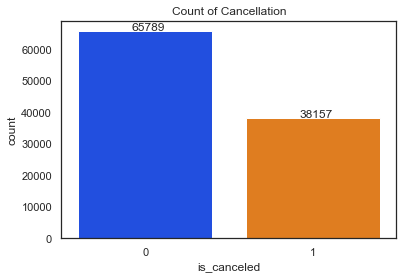

In [19]:
sns.set(style = 'white')
plt.title('Count of Cancellation', fontdict = {'fontsize': 12})
ax = sns.countplot(x='is_canceled', data=selected, palette='bright')
for p in ax.patches:
    ax.annotate((p.get_height()),(p.get_x()+0.32 , p.get_height()+100))

### Handling Imbalanced Data

From the boxplot above, seems like number of cancellation and number of success reservations are still imbalance. We try to balance them by downsampling the majority classes and combine it with minority classes. Let's see the code below.

#### Notes:

- Majority Class: The class (or classes) in an imbalanced classification predictive modeling problem that has many examples.
- Minority Class: The class in an imbalanced classification predictive modeling problem that has few examples.

In [20]:
# separate majority and minority classes
major = selected[selected['is_canceled'] == 0]
minor = selected[selected['is_canceled'] == 1]

# downsample majority class
downsampled = resample(major, replace=False, n_samples=len(minor), random_state=123) 

# combine minority class with downsampled majority class
df_new = pd.concat([downsampled, minor])

# display new class counts
df_new['is_canceled'].value_counts()

1    38157
0    38157
Name: is_canceled, dtype: int64

 Data of cancellation and succes reservations is already balanced.

In [21]:
X = df_new.drop('is_canceled', axis=1)
y = df_new['is_canceled']

### Split dataset into Train and Test

- Train size = .8
- Test sixe = .2

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

#### Create Class to store metrics and Plot ROC Curve function

In [23]:
class Report:
    def __init__(self, X_test, y_test):
        self.X = X_test
        self.y = y_test
    
    def metrics(self, model):
        y_pred = model.predict(self.X)
        
        print('Accuracy score:\n')
        print(accuracy_score(self.y, y_pred))
        
        print('\nConfusion Matrix:\n')
        print(confusion_matrix(self.y, y_pred))
        
        print('\nClassification Report:\n')
        print(classification_report(self.y, y_pred))
    
    def plot_roc_curve(self, model, part='h1', save=False):
        probs = model.predict_proba(self.X)
        preds = probs[:, 1]

        fpr, tpr, threshold = roc_curve(self.y, preds)
        roc_auc = auc(fpr, tpr)

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        
        if save:
            name = model.__class__.__name__
            plt.savefig(f'./images/{name}_{part}.png')
        plt.show()

In [24]:
report = Report(X_test, y_test)

### Modelling

We will use 3 classification models for our predictive Machine Learnig. Those are:
- Logistic Regression: a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.
- K-Nearest-Neighbors: a simple algorithm that stores all the available cases and classifies the new data or case based on a similarity measure. It is mostly used to classifies a data point based on how its neighbours are classified.
- Random Forest Classifier: 

#### 1. Logistic Regression

Accuracy score:

0.7681320841250082

Confusion Matrix:

[[6255 1428]
 [2111 5469]]

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      7683
           1       0.79      0.72      0.76      7580

    accuracy                           0.77     15263
   macro avg       0.77      0.77      0.77     15263
weighted avg       0.77      0.77      0.77     15263



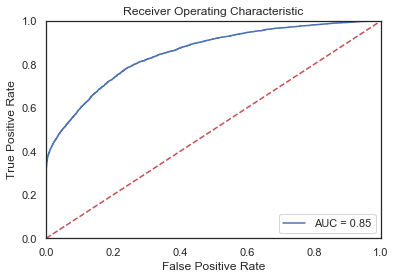

In [25]:
log = LogisticRegression().fit(X_train, y_train)

report.metrics(log)
report.plot_roc_curve(log)

In [59]:
from sklearn.metrics import recall_score

log_score = cross_val_score(log, X_test, y_test, cv=10).mean()
log_trainScore = log.score(X_train, y_train)
log_testScore = log.score(X_test, y_test)

print('LogisticRegression Cross Validation Score: {}'.format(log_score))
print('LogisticRegression Train Score: {}'.format(log_trainScore))
print('LogisticRegression Test Score: {}'.format(log_testScore))

LogisticRegression Cross Validation Score: 0.7650537163730871
LogisticRegression Train Score: 0.7644756023652356
LogisticRegression Test Score: 0.7681320841250082
[[0.37918025 0.62081975]
 [0.08485902 0.91514098]
 [0.00830363 0.99169637]
 ...
 [0.28848875 0.71151125]
 [0.18233783 0.81766217]
 [0.30068531 0.69931469]]


#### 2. K-Nearest Neighbors

In [28]:
knn = KNeighborsClassifier().fit(X_train, y_train)

Accuracy score:

0.7386490205071087

Confusion Matrix:

[[5652 2031]
 [1958 5622]]

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      7683
           1       0.73      0.74      0.74      7580

    accuracy                           0.74     15263
   macro avg       0.74      0.74      0.74     15263
weighted avg       0.74      0.74      0.74     15263



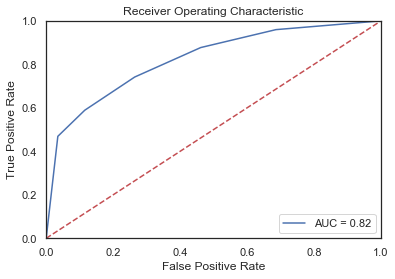

In [29]:
report.metrics(knn)
report.plot_roc_curve(knn)

In [30]:
knn_score = cross_val_score(knn, X_test, y_test, cv=10).mean()
knn_trainScore = knn.score(X_train, y_train)
knn_testScore = knn.score(X_test, y_test)

print('KNN Cross Validation Score: {}'.format(knn_score))
print('KNN Train Score: {}'.format(knn_trainScore))
print('KNN Test Score: {}'.format(knn_testScore))

KNN Cross Validation Score: 0.6842693036912679
KNN Train Score: 0.8260634551440599
KNN Test Score: 0.7386490205071087


#### 3. Random Forest Classifer

In [31]:
rfc = RandomForestClassifier().fit(X_train, y_train)

Accuracy score:

0.8717159143025618

Confusion Matrix:

[[6729  954]
 [1004 6576]]

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      7683
           1       0.87      0.87      0.87      7580

    accuracy                           0.87     15263
   macro avg       0.87      0.87      0.87     15263
weighted avg       0.87      0.87      0.87     15263



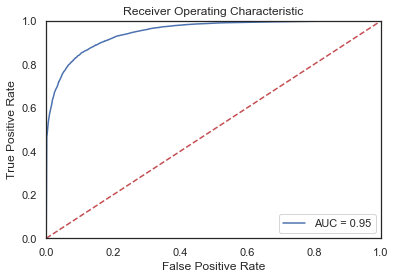

In [32]:
report.metrics(rfc)
report.plot_roc_curve(rfc)

In [49]:
rfc_score = cross_val_score(rfc, X_test, y_test, cv=10).mean()
rfc_trainScore = rfc.score(X_train, y_train)
rfc_testScore = rfc.score(X_test, y_test)

print('RandomForest Cross Validation Score: {}'.format(rfc_score))
print('RandomForest Train Score: {}'.format(rfc_trainScore))
print('RandomForest Test Score: {}'.format(rfc_testScore))

RandomForest Cross Validation Score: 0.8577615159544107
RandomForest Train Score: 0.9949877970876808
RandomForest Test Score: 0.8717159143025618


In [34]:
compare_score = pd.DataFrame({'Model' : ['LogRegression', 'KNNeighbors', 'RandomForest'], 
                              'CrossVal Score': [log_score, knn_score, rfc_score],
                             'Train Score': [log_trainScore, knn_trainScore, rfc_trainScore],
                             'Test Score': [log_testScore, knn_testScore, rfc_testScore]})

compare_score.head()

,Model,CrossVal Score,Train Score,Test Score
0,LogRegression,0.765054,0.764476,0.768132
1,KNNeighbors,0.684269,0.826063,0.738649
2,RandomForest,0.856845,0.994988,0.871716


From default models above, we can see RandomForestClassifer has the best cross validation score and best model score with train & test data. Therefore, we choose it as our prediction model. Let's try tuning the hyperparameter to get the better result.

### HyperParameter tuning using GridSearchCV

In [36]:
rfc_params = {
    'max_depth': [5, 10, 15, 20],
    'max_features': [2, 3, 5],
    'n_estimators': [100, 500, 1000],
    'min_samples_split': [5, 10, 15],
}

In [37]:
from sklearn.model_selection import GridSearchCV
params = {
    'estimator': rfc,
    'param_grid': rfc_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
rfc_cv = GridSearchCV(**params)

In [38]:
model = rfc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 45.8min finished


In [39]:
rfc_cv.best_params_

{'max_depth': 20,
 'max_features': 5,
 'min_samples_split': 5,
 'n_estimators': 500}

In [40]:
rf = RandomForestClassifier(**rfc_cv.best_params_).fit(X_train, y_train)

Accuracy score:

0.8711262530302037

Confusion Matrix:

[[6761  922]
 [1045 6535]]

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      7683
           1       0.88      0.86      0.87      7580

    accuracy                           0.87     15263
   macro avg       0.87      0.87      0.87     15263
weighted avg       0.87      0.87      0.87     15263



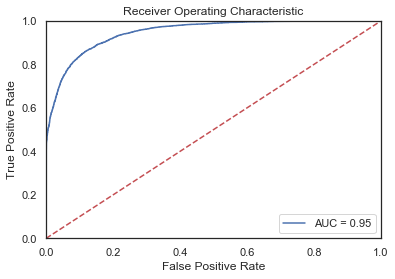

In [41]:
report.metrics(rf)
report.plot_roc_curve(rf)

In [51]:
rf_score = cross_val_score(rf, X_test, y_test, cv=10).mean()
rf_trainScore = rf.score(X_train, y_train)
rf_testScore = rf.score(X_test, y_test)

print('RandomForest Cross Validation Score: {}'.format(rf_score))
print('RandomForest Train Score: {}'.format(rf_trainScore))
print('RandomForest Test Score: {}'.format(rf_testScore))

RandomForest Cross Validation Score: 0.8550102952447899
RandomForest Train Score: 0.9072087271297767
RandomForest Test Score: 0.8711262530302037


In [52]:
compare_rfc = pd.DataFrame({'Random Forest Model' : ['Default', 'Hyperparameter'], 
                            'CrossVal Score': [rfc_score, rf_score],
                           'Train Score': [rfc_trainScore, rf_trainScore],
                           'Test Score': [rfc_testScore, rf_testScore]})

compare_rfc.head()

,Random Forest Model,CrossVal Score,Train Score,Test Score
0,Default,0.857762,0.994988,0.871716
1,Hyperparameter,0.855010,0.907209,0.871126


The defaut model is slightly better that the tuned one. It's interesting to see, maybe we can add some parameters to get the best one for future analysis and until I get the powerful device to do so. For now, we stick to the result above and will use the default one to predict.

In [53]:
prediction = rfc.predict(X_test)

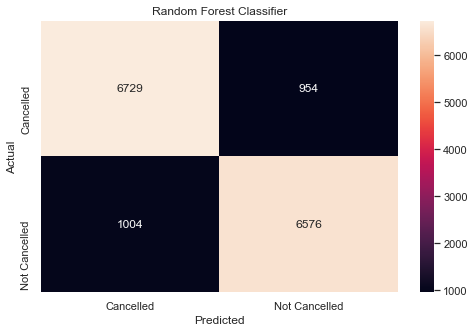

In [54]:
conf_matrix = confusion_matrix(y_test, prediction)

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", ax=ax)

labels = ['Cancelled', 'Not Cancelled']

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Feature Importances

In [55]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rfc.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)

Text(0.5, 0, 'Feature Importances (%)')

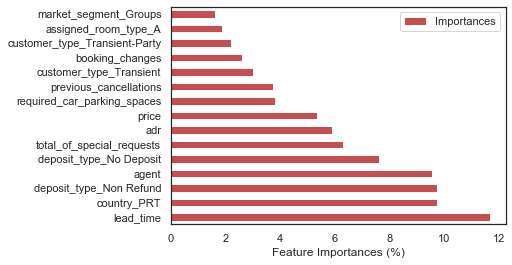

In [56]:
pd.DataFrame(data = rf.feature_importances_*100,
                   columns = ["Importances"],
                   index = X_train.columns).sort_values("Importances", ascending = False)[:15].plot(kind = "barh", color = "r")

plt.xlabel("Feature Importances (%)")

From the plot above, we can see _**lead_time**_ is the most important feature and has the most valuable feature in our prediction model. It makes sense because the longer the time gap between room booked and guest arrival, the greater possibility guests cancel their booking. Therefore, hotels can pay attention more about their cancellation policy regarding how long the lead time is.

### Deploy Model

In [58]:
import joblib
joblib.dump(rfc, "RandomForestClassifierModel")

['RandomForestClassifierModel']